In [1]:
from utils.load_dataset import PlantVillageDataset
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import cv2
from utils.preprocessing import preprocessing_img
import numpy as np
import torchvision.models  as models
from torchvision import transforms

In [3]:
# Load the dataset
PATH = './Plant_leave_diseases_dataset_without_augmentation'
transform = transforms.Compose([
    preprocessing_img,
    transforms.ToTensor(),
])
training_data = PlantVillageDataset(PATH, img_mode="LAB", train=True, transform=transform)
test_data = PlantVillageDataset(PATH, img_mode="LAB", train=False, transform=transform)

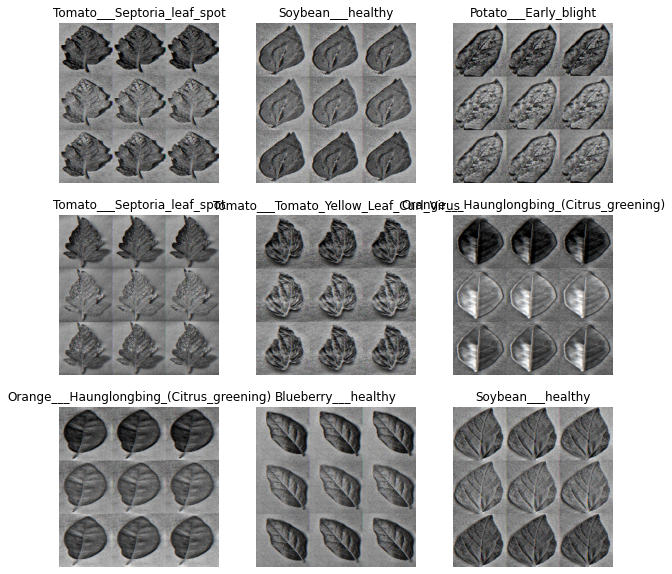

In [4]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(list(training_data.label_to_idx.keys())[label])
    plt.axis("off")
    plt.imshow(img.reshape((224, 224, 3)))
plt.show()

In [53]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [54]:
resnet50 = models.resnet50(weights='ResNet50_Weights.DEFAULT')
for param in resnet50.parameters():
    param.requires_grad = False
# efficientnet_b0 = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT', include_top = False)
# efficientnet_b3 = models.efficientnet_b3(weights='EfficientNet_B3_Weights.DEFAULT', include_top =  False)
# densenet = models.densenet121(weights='DenseNet121_Weights.DEFAULT', include_top = False)

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [56]:
resnet50 = resnet50.to(device)
efficientnet_b0 = efficientnet_b0.to(device)
efficientnet_b3 = efficientnet_b3.to(device)
densenet = densenet.to(device)

NameError: name 'efficientnet_b0' is not defined

In [57]:
# Linear Model
import torch.nn as nn
class LinearHeadModel(nn.Module):
    
    def __init__(self, input_dim, output_dim, dropout_rate=0.25):
        super(LinearHeadModel, self).__init__()
        #self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.batch_norm = nn.BatchNorm1d(input_dim)
        self.linear_layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.Dropout(dropout_rate),
            nn.Linear(64, output_dim),
            nn.Softmax(1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.batch_norm(x)
        x = self.linear_layers(x)
        return x

In [58]:
def train_model(model, train_loader, criterion, optimizer, epochs=50):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

In [59]:
resnet_linear_classifier = LinearHeadModel(150528, 39)
resnet50.fc = resnet_linear_classifier
resenet_classifier = train_model(resnet_linear_classifier, train_dataloader, nn.CrossEntropyLoss(), torch.optim.Adam(resnet50.fc.parameters(), lr=0.001))

Epoch 1/50, Loss: 3.521042749268511


KeyboardInterrupt: 